# Preliminary operation and Import Packages

In [3]:
!nvidia-smi

Tue Feb  7 16:28:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |   1838MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2996846242452572785
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1225944676
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18166989647878258434
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [5]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.utils import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras import regularizers
from tensorflow import initializers
from keras.layers import LSTM
# from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.models import load_model
from keras.layers import Activation

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

# Image management
import cv2

from time import time
import sys
import os
import glob2 as glob
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.linalg import fractional_matrix_power

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils import class_weight 

import pydot
import pydotplus
from pydotplus import graphviz

In [ ]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [10,10] # width, height

In [5]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112')

# Image generator

In [13]:
batch_size = 32 # Batch size

train_path = './train'
test_path = './test' 

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [42]:
train_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='training',
        class_mode='categorical')

Found 23524 images belonging to 3 classes.


In [43]:
validation_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='validation',
        class_mode='categorical')

Found 5880 images belonging to 3 classes.


In [44]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 397 images belonging to 3 classes.


In [45]:
train_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [46]:
validation_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

In [47]:
test_data.class_indices

{'COVID-19': 0, 'normal': 1, 'pneumonia': 2}

# Definizione dell'architettura

In [49]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [50]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/NoBalance/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [24]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_nobal = keras.Model(inputs, outputs)



In [26]:
net_dcnn_112_nobal.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 16)      448       
                                                                 
 activation (Activation)     (None, 112, 112, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_1 (Activation)   (None, 112, 112, 32)      0         
                                                             

In [27]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top k accuracy'),
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

NameError: name 'train_data' is not defined

# Fit 

In [23]:
net_dcnn_112_nobal.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

NameError: name 'net_dcnn_112_nobal' is not defined

In [55]:
history_dcnn_nobal = net_dcnn_112_nobal.fit(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

Epoch 1/50


C:\Users\marco\AppData\Local\Temp\ipykernel_21012\265271607.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_dcnn = net_dcnn_112_cw.fit_generator(train_data,


735/735 [==============================] - 74s 93ms/step - loss: 0.5975 - accuracy: 0.7527 - precision: 0.8104 - recall: 0.6738 - auc: 0.9047 - top k accuracy: 1.0000 - val_loss: 0.4308 - val_accuracy: 0.8354 - val_precision: 0.8781 - val_recall: 0.7823 - val_auc: 0.9542 - val_top k accuracy: 1.0000
Epoch 2/50
735/735 [==============================] - 67s 92ms/step - loss: 0.4602 - accuracy: 0.8189 - precision: 0.8594 - recall: 0.7721 - auc: 0.9438 - top k accuracy: 1.0000 - val_loss: 0.3609 - val_accuracy: 0.8632 - val_precision: 0.8969 - val_recall: 0.8212 - val_auc: 0.9690 - val_top k accuracy: 1.0000
Epoch 3/50
735/735 [==============================] - 65s 88ms/step - loss: 0.4089 - accuracy: 0.8403 - precision: 0.8721 - recall: 0.8007 - auc: 0.9556 - top k accuracy: 1.0000 - val_loss: 0.3178 - val_accuracy: 0.8692 - val_precision: 0.8875 - val_recall: 0.8528 - val_auc: 0.9725 - val_top k accuracy: 1.0000
Epoch 4/50
735/735 [==============================] - 67s 91ms/step - loss:

In [1]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/NoBalance/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_nobal.history)

NameError: name 'np' is not defined

In [13]:
history_dcnn_nobal = np.load('C:/Users/marco/Desktop/Local_Documents/models/NoBalance/dcnn_history_112_v1.npy', allow_pickle=True).item()

# Evaluation

## Training - Validation

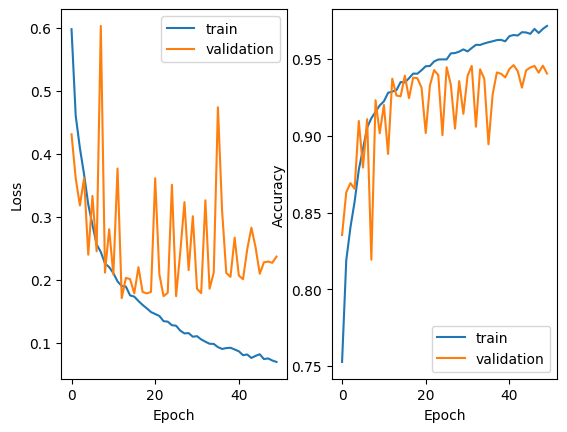

In [21]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_nobal['loss'])
plt.plot(history_dcnn_nobal['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_nobal['accuracy'])
plt.plot(history_dcnn_nobal['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

## Test set

In [ ]:
# Load model


In [22]:
# Evaluation
score = net_dcnn_112_nobal.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

NameError: name 'net_dcnn_112_nobal' is not defined